In [4]:
# Import packages
import sqlite3
import pandas as pd
import numpy as np
import os

All Parameters that can be adjusted as a part of this analysis

In [2]:
# Config
DB_PATH = "cfb_data.db"
PRE_GAME_ELO_CSV_PATH = 'games_with_pregame_elo.csv'
#Define RP metrics to load and use
RP_METRICS_TO_USE =['usage','percentPPA']
# Define dfault value for missing RP data (e.g., average)
DEFAULT_RP_VALUE = 0.5
# Define how many weeks RP features should be active
RP_ACTIVE_WEEKS = 4
#Betting Parameters
BET_THRESHOLD = 0.5
WIN_PAYOUT = 0.909
LOSS_AMOUNT = 1

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Define the path to your desired directory in Google Drive
drive_path = '/content/drive/MyDrive/Betting/BettingModels'

# Change the current working directory to the desired location
os.chdir(drive_path)

# Verify the current working directory (optional)
print(f"Current working directory: {os.getcwd()}")
from opponent_adjustments import get_opponent_adjustments

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Betting/BettingModels


# Phase 1: Data Foundation and Feature Engineering

## Step 1: Data Consolidation

In [ ]:
print(f"Connecting to database: {DB_PATH}")
conn = sqlite3.connect(DB_PATH)

# Load games_full data - Select ALL potentially relevant columns
# Explicitly listing columns is generally better than SELECT *
# Make sure this list matches the columns in your 'games_full' table
# (Derived from your initial dataset_head.csv)
all_feature_columns = [
    'id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'conference_game', 'attendance', 'home_team', 'home_conference',
    'home_division', 'home_points', 'home_post_win_prob', 'home_pregame_elo', # Note: We use our CALC'd elo later
    'home_postgame_elo', 'away_team', 'away_conference', 'away_division',
    'away_points', 'away_post_win_prob', 'away_pregame_elo', # Note: We use our CALC'd elo later
    'away_postgame_elo', 'avg_closing_spread', 'avg_closing_total',
    'avg_opening_spread', 'avg_opening_total',
    # Home Offense Stats
    'home_offense_plays', 'home_offense_drives', 'home_offense_ppa',
    'home_offense_totalPPA', 'home_offense_successRate', 'home_offense_explosiveness',
    'home_offense_powerSuccess', 'home_offense_stuffRate', 'home_offense_lineYards',
    'home_offense_lineYardsTotal', 'home_offense_secondLevelYards',
    'home_offense_secondLevelYardsTotal', 'home_offense_openFieldYards',
    'home_offense_openFieldYardsTotal', 'home_offense_standardDowns_ppa',
    'home_offense_standardDowns_successRate', 'home_offense_standardDowns_explosiveness',
    'home_offense_passingDowns_ppa', 'home_offense_passingDowns_successRate',
    'home_offense_passingDowns_explosiveness', 'home_offense_rushingPlays_ppa',
    'home_offense_rushingPlays_totalPPA', 'home_offense_rushingPlays_successRate',
    'home_offense_rushingPlays_explosiveness', 'home_offense_passingPlays_ppa',
    'home_offense_passingPlays_totalPPA', 'home_offense_passingPlays_successRate',
    'home_offense_passingPlays_explosiveness',
    # Home Defense Stats
    'home_defense_plays', 'home_defense_drives', 'home_defense_ppa',
    'home_defense_totalPPA', 'home_defense_successRate', 'home_defense_explosiveness',
    'home_defense_powerSuccess', 'home_defense_stuffRate', 'home_defense_lineYards',
    'home_defense_lineYardsTotal', 'home_defense_secondLevelYards',
    'home_defense_secondLevelYardsTotal', 'home_defense_openFieldYards',
    'home_defense_openFieldYardsTotal', 'home_defense_standardDowns_ppa',
    'home_defense_standardDowns_successRate', 'home_defense_standardDowns_explosiveness',
    'home_defense_passingDowns_ppa', 'home_defense_passingDowns_successRate',
    'home_defense_passingDowns_explosiveness', 'home_defense_rushingPlays_ppa',
    'home_defense_rushingPlays_totalPPA', 'home_defense_rushingPlays_successRate',
    'home_defense_rushingPlays_explosiveness', 'home_defense_passingPlays_ppa',
    'home_defense_passingPlays_totalPPA', 'home_defense_passingPlays_successRate',
    'home_defense_passingPlays_explosiveness',
    # Away Offense Stats (matches home offense structure)
    'away_offense_plays', 'away_offense_drives', 'away_offense_ppa',
    'away_offense_totalPPA', 'away_offense_successRate', 'away_offense_explosiveness',
    'away_offense_powerSuccess', 'away_offense_stuffRate', 'away_offense_lineYards',
    'away_offense_lineYardsTotal', 'away_offense_secondLevelYards',
    'away_offense_secondLevelYardsTotal', 'away_offense_openFieldYards',
    'away_offense_openFieldYardsTotal', 'away_offense_standardDowns_ppa',
    'away_offense_standardDowns_successRate', 'away_offense_standardDowns_explosiveness',
    'away_offense_passingDowns_ppa', 'away_offense_passingDowns_successRate',
    'away_offense_passingDowns_explosiveness', 'away_offense_rushingPlays_ppa',
    'away_offense_rushingPlays_totalPPA', 'away_offense_rushingPlays_successRate',
    'away_offense_rushingPlays_explosiveness', 'away_offense_passingPlays_ppa',
    'away_offense_passingPlays_totalPPA', 'away_offense_passingPlays_successRate',
    'away_offense_passingPlays_explosiveness',
    # Away Defense Stats (matches home defense structure)
    'away_defense_plays', 'away_defense_drives', 'away_defense_ppa',
    'away_defense_totalPPA', 'away_defense_successRate', 'away_defense_explosiveness',
    'away_defense_powerSuccess', 'away_defense_stuffRate', 'away_defense_lineYards',
    'away_defense_lineYardsTotal', 'away_defense_secondLevelYards',
    'away_defense_secondLevelYardsTotal', 'away_defense_openFieldYards',
    'away_defense_openFieldYardsTotal', 'away_defense_standardDowns_ppa',
    'away_defense_standardDowns_successRate', 'away_defense_standardDowns_explosiveness',
    'away_defense_passingDowns_ppa', 'away_defense_passingDowns_successRate',
    'away_defense_passingDowns_explosiveness', 'away_defense_rushingPlays_ppa',
    'away_defense_rushingPlays_totalPPA', 'away_defense_rushingPlays_successRate',
    'away_defense_rushingPlays_explosiveness', 'away_defense_passingPlays_ppa',
    'away_defense_passingPlays_totalPPA', 'away_defense_passingPlays_successRate',
    'away_defense_passingPlays_explosiveness',
    # Other stats
    'home_turnovers', 'home_possessionTime', 'away_turnovers', 'away_possessionTime'
]

# Construct the SQL query string dynamically
select_clause = ",\n    ".join([f"g.{col}" for col in all_feature_columns])
games_query = f"""
SELECT
    {select_clause}
FROM
    games_full g
WHERE
    g.completed = 1 -- Only use completed games
ORDER BY
    g.season, g.week, g.id;
"""
# print(games_query) # Optional: Print the generated query to verify

print("Loading ALL games data (including advanced stats)...")
games_df = pd.read_sql_query(games_query, conn)
print(f"Loaded {len(games_df)} completed games with {len(games_df.columns)} columns.")



Connecting to database: cfb_data.db
Loading ALL games data (including advanced stats)...
Loaded 9816 completed games with 142 columns.


### Returning Production Data

In [ ]:
# --- Load Returning Production Data ---
rp_cols_select = ['season', 'team'] + RP_METRICS_TO_USE
rp_cols_str = ", ".join(rp_cols_select)
rp_query = f"SELECT {rp_cols_str} FROM returning_production;"
print(f"Loading returning production data ({RP_METRICS_TO_USE})...")
rp_df = pd.read_sql_query(rp_query, conn)
print(f"Loaded {len(rp_df)} returning production records.")


conn.close()
print("Database connection closed.")

Loading returning production data (['usage', 'percentPPA'])...
Loaded 1420 returning production records.
Database connection closed.


### Pre-processing Games Data

In [ ]:
# Convert boolean-like columns to integers (0 or 1) for models
games_df['neutral_site'] = games_df['neutral_site'].astype(int)
games_df['conference_game'] = games_df['conference_game'].astype(int)

# Convert spread/total/score columns to numeric, coercing errors to NaN
numeric_cols = ['avg_closing_spread', 'avg_closing_total', 'avg_opening_spread',
                'avg_opening_total', 'home_points', 'away_points',
                'attendance', 'home_possessionTime', 'away_possessionTime',
                # Add Elo/win prob if needed, though we'll use our own Elo primarily
                'home_post_win_prob', 'home_pregame_elo', 'home_postgame_elo',
                'away_post_win_prob', 'away_pregame_elo', 'away_postgame_elo']

# Convert all advanced stat columns to numeric
# Identify the first advanced stat column to loop from there
first_adv_stat_col = 'home_offense_plays'
first_adv_stat_idx = games_df.columns.get_loc(first_adv_stat_col)
adv_stat_cols = games_df.columns[first_adv_stat_idx:]

numeric_cols.extend(adv_stat_cols)

print("Converting relevant columns to numeric...")
for col in numeric_cols:
    if col in games_df.columns: # Check if column exists (robustness)
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')

# Report missing values for key targets/inputs after conversion
check_missing_cols = ['avg_closing_spread', 'home_points', 'away_points']
print("Missing value check (post-numeric conversion):")
for col in check_missing_cols:
     if col in games_df.columns:
        missing_pct = games_df[col].isnull().mean() * 100
        print(f"  Column '{col}' missing: {missing_pct:.2f}%")

# Drop rows where essential score data might be missing after conversion
games_df.dropna(subset=['home_points', 'away_points'], inplace=True)

Converting relevant columns to numeric...
Missing value check (post-numeric conversion):
  Column 'avg_closing_spread' missing: 0.95%
  Column 'home_points' missing: 0.00%
  Column 'away_points' missing: 0.00%


### Pre-Processing Returning Production Data



In [ ]:
print("Preprocessing returning production data...")
# Convert RP metrics to numeric
for col in RP_METRICS_TO_USE:
    rp_df[col] = pd.to_numeric(rp_df[col], errors='coerce')
# Fill missing RP values *before* merging
print(f"Filling NaNs in RP data with default: {DEFAULT_RP_VALUE}")
rp_df.fillna({col: DEFAULT_RP_VALUE for col in RP_METRICS_TO_USE}, inplace=True)
# Prepare for merge - RP data for season S applies to season S games
rp_df.rename(columns={'season': 'rp_season'}, inplace=True) # Avoid collision with game season

Preprocessing returning production data...
Filling NaNs in RP data with default: 0.5


### Load Pre-Calculated Elo Ratings

In [ ]:
print(f"Loading pre-game Elo ratings from: {PRE_GAME_ELO_CSV_PATH}")
pre_game_elo_df = pd.read_csv(PRE_GAME_ELO_CSV_PATH)
pre_game_elo_df = pre_game_elo_df[['game_id', 'home_pregame_elo', 'away_pregame_elo']]
print(f"Loaded Elo ratings for {len(pre_game_elo_df)} games.")

# Rename columns to avoid conflict with original Elo cols and clarify source
pre_game_elo_df.rename(columns={
    'home_pregame_elo': 'home_pregame_elo_calc',
    'away_pregame_elo': 'away_pregame_elo_calc'
}, inplace=True)

Loading pre-game Elo ratings from: games_with_pregame_elo.csv
Loaded Elo ratings for 9816 games.


### Merge Games and Elo Data

In [ ]:
print("Merging games data with pre-game Elo ratings...")
master_df = pd.merge(
    games_df,
    pre_game_elo_df,
    left_on='id',
    right_on='game_id',
    how='left'
)

# Check for games potentially missed by the merge
missing_elo_count = master_df['home_pregame_elo_calc'].isnull().sum()
if missing_elo_count > 0:
    print(f"Warning: {missing_elo_count} games are missing calculated pre-game Elo ratings after merge.")
    # Depending on strategy, might drop these rows later if calc'd Elo is crucial
    # master_df.dropna(subset=['home_pregame_elo_calc', 'away_pregame_elo_calc'], inplace=True)

master_df.drop(columns=['game_id'], inplace=True)

Merging games data with pre-game Elo ratings...


### Merge Returning Production Data

In [ ]:
print("Merging returning production data...")
# Merge for Home Team
master_df = pd.merge(
    master_df,
    rp_df,
    left_on=['season', 'home_team'],
    right_on=['rp_season', 'team'],
    how='left',
    suffixes=('', '_rp_home_temp')
)
# Rename home RP columns and drop temporary merge keys
home_rp_rename = {col: f'home_rp_{col}' for col in RP_METRICS_TO_USE}
master_df.rename(columns=home_rp_rename, inplace=True)
master_df.drop(columns=['rp_season', 'team'], inplace=True, errors='ignore')

# Merge for Away Team
master_df = pd.merge(
    master_df,
    rp_df,
    left_on=['season', 'away_team'],
    right_on=['rp_season', 'team'],
    how='left',
    suffixes=('', '_rp_away_temp')
)
# Rename away RP columns and drop temporary merge keys
away_rp_rename = {col: f'away_rp_{col}' for col in RP_METRICS_TO_USE}
master_df.rename(columns=away_rp_rename, inplace=True)
master_df.drop(columns=['rp_season', 'team'], inplace=True, errors='ignore')

# Fill NaNs for teams potentially missing in RP data *after* merge (use default)
home_rp_cols = list(home_rp_rename.values())
away_rp_cols = list(away_rp_rename.values())
rp_cols_merged = home_rp_cols + away_rp_cols
for col in rp_cols_merged:
    if master_df[col].isnull().any():
        print(f"Filling NaNs in merged RP column '{col}' with {DEFAULT_RP_VALUE}")
        master_df[col].fillna(DEFAULT_RP_VALUE, inplace=True)

Merging returning production data...
Filling NaNs in merged RP column 'home_rp_usage' with 0.5
Filling NaNs in merged RP column 'home_rp_percentPPA' with 0.5
Filling NaNs in merged RP column 'away_rp_usage' with 0.5
Filling NaNs in merged RP column 'away_rp_percentPPA' with 0.5


<ipython-input-11-8b23a078025e>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(DEFAULT_RP_VALUE, inplace=True)


### Critical: Drop Target Variable Missing Data and Sort Chronologically

In [ ]:
print("Sorting final DataFrame chronologically...")
master_df.sort_values(by=['season', 'week', 'id'], inplace=True)
master_df.reset_index(drop=True, inplace=True)

Sorting final DataFrame chronologically...


### Inspect Consolidated Data

In [ ]:
print("\n--- Master DataFrame Info (Now includes all stats) ---")
master_df.info() # Will show many more columns now

# Displaying head/tail might be too wide, focus on key columns
print("\n--- Master DataFrame Head (Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].head())

print("\n--- Master DataFrame Tail (Check Sorting - Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].tail())


--- Master DataFrame Info (Now includes all stats) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Columns: 148 entries, id to away_rp_percentPPA
dtypes: float64(135), int64(6), object(7)
memory usage: 11.1+ MB

--- Master DataFrame Head (Key Columns) ---
          id  season  week       home_team         away_team  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   avg_closing_spread  avg_opening_spread  home_pregame_elo_calc  \
0          -41.000000                 NaN                 1500.0   
1          -33.000000                 NaN                 1500.0   
2          -20.000000                 NaN                 1500.0   
3           22.833333                 NaN               

## Step 2: Definte Target Variable & Basic Features

In [ ]:
# Define the primary target variable
target_variable = 'avg_closing_spread'
print(f"\nTarget Variable: '{target_variable}'")

# Check target missing values
target_missing_pct = master_df[target_variable].isnull().mean() * 100
print(f"Missing values in target ('{target_variable}'): {target_missing_pct:.2f}%")

# Drop rows where the target variable is NaN
master_df.dropna(subset=[target_variable], inplace=True)
master_df.reset_index(drop=True, inplace=True)

# Verify the target column now has no NaNs
print(f"Missing values in target after dropping: {master_df[target_variable].isnull().sum()}")

# Define initial, basic features (using our CALCULATED Elo)
# Note: We exclude the original home/away_pregame_elo from the DB unless needed for comparison
basic_features = [
    'home_pregame_elo_calc', # Our calculated Elo
    'away_pregame_elo_calc', # Our calculated Elo
    'neutral_site',
    'conference_game',
    'season',
    'week'
]
# Engineer Elo difference feature using our calculated Elo
master_df['elo_diff_calc'] = master_df['home_pregame_elo_calc'] - master_df['away_pregame_elo_calc']
basic_features.append('elo_diff_calc')

print(f"\nBasic Features Selected ({len(basic_features)}):")
print(basic_features)

# Display the target and basic features for a few rows
print("\n--- Target and Basic Features (Head) ---")
# Handle potential missing calculated Elo values if not dropped earlier
print(master_df[[target_variable] + basic_features].head())


Target Variable: 'avg_closing_spread'
Missing values in target ('avg_closing_spread'): 0.95%
Missing values in target after dropping: 0

Basic Features Selected (7):
['home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutral_site', 'conference_game', 'season', 'week', 'elo_diff_calc']

--- Target and Basic Features (Head) ---
   avg_closing_spread  home_pregame_elo_calc  away_pregame_elo_calc  \
0          -41.000000                 1500.0                 1200.0   
1          -33.000000                 1500.0                 1200.0   
2          -20.000000                 1500.0                 1200.0   
3           22.833333                 1500.0                 1500.0   
4          -30.500000                 1500.0                 1200.0   

   neutral_site  conference_game  season  week  elo_diff_calc  
0             1                0    2013     1          300.0  
1             0                0    2013     1          300.0  
2             0                0    2013     1     

## Step 3 Advanced Stat Feature Engineering

### Identify Stats for Rolling Averages

In [ ]:
# Select key efficiency/explosiveness metrics. Start with a focused list.
# Expand this list later if needed.
stats_to_roll = [
    # Overall Offense
    'offense_ppa',
    'offense_successRate',
    'offense_explosiveness',
    # Rushing Offense
    'offense_rushingPlays_ppa',
    'offense_rushingPlays_successRate',
    'offense_rushingPlays_explosiveness',
    'offense_lineYards', # Potentially useful offensive line proxy
    # Passing Offense
    'offense_passingPlays_ppa',
    'offense_passingPlays_successRate',
    'offense_passingPlays_explosiveness',
    # Standard Downs
    'offense_standardDowns_ppa',
    'offense_standardDowns_successRate',
    'offense_standardDowns_explosiveness',
    # Passing Downs
    'offense_passingDowns_ppa',
    'offense_passingDowns_successRate',
    'offense_passingDowns_explosiveness',
    # Overall Defense (using opponent's offensive stats)
    'defense_ppa',
    'defense_successRate',
    'defense_explosiveness',
    # Rushing Defense
    'defense_rushingPlays_ppa',
    'defense_rushingPlays_successRate',
    'defense_rushingPlays_explosiveness',
    'defense_lineYards', # Potentially useful defensive line proxy
    # Passing Defense
    'defense_passingPlays_ppa',
    'defense_passingPlays_successRate',
    'defense_passingPlays_explosiveness',
    # Standard Downs
    'defense_standardDowns_ppa',
    'defense_standardDowns_successRate',
    'defense_standardDowns_explosiveness',
    # Passing Downs
    'defense_passingDowns_ppa',
    'defense_passingDowns_successRate',
    'defense_passingDowns_explosiveness',
    # Special Teams / Other (Add if desired, e.g., avg starting field position - needs raw data)
    'turnovers' # Average turnovers forced/committed
]

# Define EWMA span (adjust as needed, smaller span = more weight on recent)
# A span of 5 roughly means the last ~5 games have the most influence.
ewma_span = 5
min_periods_for_ewma = max(1, ewma_span // 2)

print(f"Selected {len(stats_to_roll)} stats for EWMA (span={ewma_span}).")

Selected 33 stats for EWMA (span=5).


### Reshape Data to Team-Centric Format

In [ ]:
# Create two temporary dataframes, one for home team stats, one for away
home_stats = master_df[['id', 'season', 'week', 'home_team', 'away_team']].copy()
away_stats = master_df[['id', 'season', 'week', 'away_team', 'home_team']].copy()

home_stats.rename(columns={'home_team': 'team', 'away_team': 'opponent'}, inplace=True)
away_stats.rename(columns={'away_team': 'team', 'home_team': 'opponent'}, inplace=True)

# Add actual stats, renaming columns to generic 'offense_*', 'defense_*'
print("Reshaping data to team-centric format...")
for stat_base in stats_to_roll:
    # Determine if it's an offense or defense stat based on original column name structure
    # This requires stats_to_roll names to match the generic part after home_/away_
    home_col = f'home_{stat_base}'
    away_col = f'away_{stat_base}'

    if home_col in master_df.columns and away_col in master_df.columns and stat_base != 'turnovers':
        # Offensive and Defensive stat for the teams
        home_stats[stat_base] = master_df[home_col]
        away_stats[stat_base] = master_df[away_col]

    # Handle turnovers specifically if included
    elif stat_base == 'turnovers':
      home_stats['turnovers_committed'] = master_df['home_turnovers']
      home_stats['turnovers_forced'] = master_df['away_turnovers'] # Home defense forced away turnovers
      away_stats['turnovers_committed'] = master_df['away_turnovers']
      away_stats['turnovers_forced'] = master_df['home_turnovers'] # Away defense forced home turnovers


# Combine home and away views
team_game_df = pd.concat([home_stats, away_stats], ignore_index=True)

Reshaping data to team-centric format...


In [ ]:
team_game_df[(team_game_df['season'] == 2024) & (team_game_df['team'] == 'Alabama')]

,id,season,week,team,opponent,offense_ppa,offense_successRate,offense_explosiveness,offense_rushingPlays_ppa,offense_rushingPlays_successRate,...,defense_passingPlays_successRate,defense_passingPlays_explosiveness,defense_standardDowns_ppa,defense_standardDowns_successRate,defense_standardDowns_explosiveness,defense_passingDowns_ppa,defense_passingDowns_successRate,defense_passingDowns_explosiveness,turnovers_committed,turnovers_forced
8865,401628319,2024,1,Alabama,Western Kentucky,1.343144,0.476190,3.393672,0.848881,0.400000,...,0.218750,1.626537,-0.334946,0.208333,0.993355,-0.111976,0.208333,1.774230,1.0,2.0
8950,401628335,2024,2,Alabama,South Florida,0.262745,0.402985,1.324513,0.222252,0.421053,...,0.230769,1.054071,-0.084724,0.375000,0.799680,-0.018798,0.153846,2.022206,3.0,0.0
9156,401628374,2024,5,Alabama,Georgia,0.294012,0.471429,1.415743,0.088653,0.303030,...,0.411765,1.863592,0.301670,0.500000,1.671896,0.199035,0.296296,1.396293,1.0,4.0
9259,401628385,2024,7,Alabama,South Carolina,0.139325,0.491803,1.116730,0.177998,0.558824,...,0.428571,1.765896,-0.021626,0.450980,0.847218,0.647312,0.400000,2.744422,2.0,4.0
9370,401628400,2024,9,Alabama,Missouri,0.242476,0.442308,1.183641,0.246868,0.480000,...,0.166667,0.819375,-0.238444,0.411765,0.623779,-0.290358,0.076923,1.885113,0.0,3.0
9532,401628425,2024,12,Alabama,Mercer,0.614156,0.567568,1.514592,0.559102,0.571429,...,0.466667,1.237692,-0.493196,0.363636,1.004340,-0.073049,0.400000,1.198271,0.0,3.0
9646,401628437,2024,14,Alabama,Auburn,0.166806,0.487179,1.011816,0.004522,0.425926,...,0.395349,1.489217,-0.015114,0.454545,0.938314,0.426650,0.333333,1.985699,4.0,2.0
18751,401628350,2024,3,Alabama,Wisconsin,0.558540,0.487179,1.560085,0.512140,0.500000,...,0.357143,1.559695,-0.000990,0.465116,0.890309,0.346370,0.375000,1.360695,0.0,2.0
18938,401628384,2024,6,Alabama,Vanderbilt,0.464147,0.555556,1.499859,0.388686,0.473684,...,0.666667,2.091545,0.057245,0.420000,1.052493,0.639085,0.416667,2.228449,2.0,0.0
19039,401628397,2024,8,Alabama,Tennessee,-0.066958,0.363636,1.040095,-0.068640,0.400000,...,0.343750,2.318390,-0.190941,0.382979,0.738230,0.462074,0.307692,2.615161,2.0,3.0


### Critical: Sort for Rolling Calculation

In [ ]:
print("Sorting team-centric data...")
team_game_df.sort_values(by=['team', 'season', 'week', 'id'], inplace=True)

Sorting team-centric data...


### Calculate Lagged EWMA

In [ ]:
print(f"Calculating SEASONAL lagged EWMAs (span={ewma_span})...")
ewma_cols_generated = []
stats_to_roll.append('turnovers_committed')
stats_to_roll.append('turnovers_forced')
stats_to_roll.remove('turnovers')
for stat in stats_to_roll:
    if stat in team_game_df.columns: # Ensure stat column was created successfully
        ewma_col_name = f'{stat}_ewma_lag1'
        # Calculate EWMA and shift within each group
        # Use transform for efficiency if possible
        team_game_df[ewma_col_name] = team_game_df.groupby('team')[stat].transform(
            lambda x: x.ewm(span=ewma_span, min_periods=min_periods_for_ewma, adjust=True).mean().shift(1)
        )
        ewma_cols_generated.append(ewma_col_name)
    else:
        print(f"Skipping EWMA for '{stat}' as column not found in team_game_df.")

print(f"Generated {len(ewma_cols_generated)} EWMA columns.")

Calculating SEASONAL lagged EWMAs (span=5)...
Generated 34 EWMA columns.


### Merge back to Master DataFrame

In [ ]:
print("Merging EWMA features back to master DataFrame...")

# Select only necessary columns from team_game_df for merging
ewma_features_to_merge = team_game_df[['id', 'team'] + ewma_cols_generated].copy()

# Merge for Home Team stats
master_df_merged = pd.merge(
    master_df,
    ewma_features_to_merge,
    left_on=['id', 'home_team'],
    right_on=['id', 'team'],
    how='left',
    suffixes=('', '_y') # Avoid suffix collision initially
)
# Rename merged columns for home team
home_ewma_rename_dict = {col: f'home_{col}' for col in ewma_cols_generated}
master_df_merged.rename(columns=home_ewma_rename_dict, inplace=True)
master_df_merged.drop(columns=['team'], inplace=True) # Drop the 'team' column from the merge

# Merge for Away Team stats
master_df_final = pd.merge(
    master_df_merged,
    ewma_features_to_merge,
    left_on=['id', 'away_team'],
    right_on=['id', 'team'],
    how='left',
    suffixes=('', '_y') # Avoid suffix collision
)
# Rename merged columns for away team
away_ewma_rename_dict = {col: f'away_{col}' for col in ewma_cols_generated}
master_df_final.rename(columns=away_ewma_rename_dict, inplace=True)
master_df_final.drop(columns=['team'], inplace=True) # Drop the 'team' column from the merge

# Clean up any potential duplicate '_y' columns if merging caused issues (shouldn't with suffixes)
cols_to_drop = [col for col in master_df_final.columns if col.endswith('_y')]
if cols_to_drop:
    print(f"Dropping potentially duplicated columns: {cols_to_drop}")
    master_df_final.drop(columns=cols_to_drop, inplace=True)
master_df = master_df_final
del master_df_merged, master_df_final # Clean up memory

Merging EWMA features back to master DataFrame...


**Note: When we have FBS vs. FCS games, all of our shifted EWM data for the FCS team is very likely to be NaN because we don't have previous games**

### Create Matchup Features

In [ ]:
print("Creating matchup features (differences)...")
matchup_features_seasonal = []
# Construct names based on the NEW 'seasonal_' prefixed EWMA columns
for stat in stats_to_roll:
  base_stat_name = stat.split('_')[-1]
  if stat.startswith('offense_'): def_equiv_stat_base = stat.replace("offense_", "")
  elif stat.startswith('defense_'): def_equiv_stat_base = stat.replace("defense_", "")
  else: def_equiv_stat_base = stat

  home_off_col = f'home_offense_{def_equiv_stat_base}_ewma_lag1'
  away_def_col = f'away_defense_{def_equiv_stat_base}_ewma_lag1'
  away_off_col = f'away_offense_{def_equiv_stat_base}_ewma_lag1'
  home_def_col = f'home_defense_{def_equiv_stat_base}_ewma_lag1'

  matchup_col_name_ho_ad = f'matchup_HO_v_AD_{def_equiv_stat_base}'
  matchup_col_name_ao_hd = f'matchup_AO_v_HD_{def_equiv_stat_base}'

  if home_off_col in master_df.columns and away_def_col in master_df.columns:
      master_df[matchup_col_name_ho_ad] = master_df[home_off_col] - master_df[away_def_col]
      if matchup_col_name_ho_ad not in matchup_features_seasonal: matchup_features_seasonal.append(matchup_col_name_ho_ad)

  if away_off_col in master_df.columns and home_def_col in master_df.columns:
      master_df[matchup_col_name_ao_hd] = master_df[away_off_col] - master_df[home_def_col]
      if matchup_col_name_ao_hd not in matchup_features_seasonal: matchup_features_seasonal.append(matchup_col_name_ao_hd)

print(f"Generated {len(matchup_features_seasonal)} SEASONAL matchup difference features.")

# Clean up memory
del team_game_df, home_stats, away_stats, ewma_features_to_merge

Creating matchup features (differences)...
Generated 32 SEASONAL matchup difference features.


### Returning Production Feature Creation

In [ ]:
print("\n--- Phase 1, Step 3 (Continued): Returning Production Features ---")

rp_features = []
rp_diff_features = []

# Create difference features and conditional features
for metric in RP_METRICS_TO_USE:
    home_rp_col = f'home_rp_{metric}'
    away_rp_col = f'away_rp_{metric}'

    # 1. Create Difference Feature
    diff_col_name = f'rp_{metric}_diff'
    master_df[diff_col_name] = master_df[home_rp_col] - master_df[away_rp_col]
    rp_diff_features.append(diff_col_name)

    # 2. Create Conditionally Active RP Features (Active Weeks 1-RP_ACTIVE_WEEKS)
    home_rp_cond_col = f'{home_rp_col}_Wk1_{RP_ACTIVE_WEEKS}'
    away_rp_cond_col = f'{away_rp_col}_Wk1_{RP_ACTIVE_WEEKS}'
    diff_cond_col = f'{diff_col_name}_Wk1_{RP_ACTIVE_WEEKS}'

    master_df[home_rp_cond_col] = np.where(master_df['week'] <= RP_ACTIVE_WEEKS, master_df[home_rp_col], 0.0)
    master_df[away_rp_cond_col] = np.where(master_df['week'] <= RP_ACTIVE_WEEKS, master_df[away_rp_col], 0.0)
    master_df[diff_cond_col] = np.where(master_df['week'] <= RP_ACTIVE_WEEKS, master_df[diff_col_name], 0.0)

    # Add the conditional features to our list
    rp_features.extend([home_rp_cond_col, away_rp_cond_col, diff_cond_col])

print(f"Created {len(rp_diff_features)} RP difference features.")
print(f"Created {len(rp_features)} conditionally active RP features (Weeks 1-{RP_ACTIVE_WEEKS}).")

# Display example RP features
print("\n--- Conditionally Active RP Features (Head - Week 1) ---")
print(master_df[master_df['week']==1][['week'] + rp_features].head())
print("\n--- Conditionally Active RP Features (Head - Week 5) ---")
print(master_df[master_df['week']==5][['week'] + rp_features].head())


# --- Update Potential Features List ---
# Redefine the full list to include new RP features and SEASONAL EWMAs
print("\nUpdating potential features list...")
# Basic features (ensure these are still relevant and exist)
basic_features = [col for col in master_df.columns if col in [
    'home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutral_site',
    'conference_game', 'season', 'week', 'elo_diff_calc']]

# Get names of the newly created seasonal EWMA and matchup columns
ewma_cols = [col for col in master_df.columns if '_ewma_lag1' in col]
matchup_cols = [col for col in master_df.columns if 'matchup_' in col]

# The new RP features are in the 'rp_features' list already

potential_features = basic_features + ewma_cols + matchup_cols + rp_features
# Remove potential duplicates if any column accidentally got added twice
potential_features = sorted(list(set(potential_features)))

print(f"Total potential features (incl. Seasonal EWMA & Conditional RP): {len(potential_features)}")


--- Phase 1, Step 3 (Continued): Returning Production Features ---
Created 2 RP difference features.
Created 6 conditionally active RP features (Weeks 1-4).

--- Conditionally Active RP Features (Head - Week 1) ---
   week  home_rp_usage_Wk1_4  away_rp_usage_Wk1_4  rp_usage_diff_Wk1_4  \
0     1                  0.5                  0.5                  0.0   
1     1                  0.5                  0.5                  0.0   
2     1                  0.5                  0.5                  0.0   
3     1                  0.5                  0.5                  0.0   
4     1                  0.5                  0.5                  0.0   

   home_rp_percentPPA_Wk1_4  away_rp_percentPPA_Wk1_4  \
0                       0.5                       0.5   
1                       0.5                       0.5   
2                       0.5                       0.5   
3                       0.5                       0.5   
4                       0.5                       0.5 

### Inspect Engineered Features

In [ ]:
print("\n--- Inspecting Engineered Features (Head) ---")
engineered_feature_cols = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col] + rp_features
print(master_df[['id', 'season', 'week', 'home_team', 'away_team'] + engineered_feature_cols].head())

# Check for NaNs introduced by lagging/EWMA (expected early season)
print("\n--- NaN check for first few EWMA features ---")
missing_pcts = []
for col in engineered_feature_cols: # Check first few
    missing_pct = master_df[col].isnull().mean() * 100
    missing_pcts.append(missing_pct)
    print(f"  Feature '{col}' missing: {missing_pct:.2f}%")


--- Inspecting Engineered Features (Head) ---
          id  season  week       home_team         away_team  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   home_offense_ppa_ewma_lag1  home_offense_successRate_ewma_lag1  \
0                         NaN                                 NaN   
1                         NaN                                 NaN   
2                         NaN                                 NaN   
3                         NaN                                 NaN   
4                         NaN                                 NaN   

   home_offense_explosiveness_ewma_lag1  \
0                                   NaN   
1                                   NaN   
2                       

## Step 4: Handling Missing Data

### Indentify and Quantify Missing Feature Values

In [ ]:
# Use the 'potential_features' list created at the end of Step 3
# If you didn't create it, define it again:
# all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
# potential_features = basic_features + all_engineered_features # basic_features defined in step 2

# Calculate missing percentage for features we might use
print(f"Checking missing values for {len(potential_features)} potential features...")
missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0] # Filter to only show columns with missing data

print("\nFeatures with Missing Values (%):")
if missing_summary.empty:
    print("No missing values found in the potential feature set.")
else:
    with pd.option_context('display.max_rows', None): # Ensure all rows are printed
        print(missing_summary)

Checking missing values for 113 potential features...

Features with Missing Values (%):
matchup_AO_v_HD_passingDowns_explosiveness            3.671706
away_offense_passingDowns_explosiveness_ewma_lag1     3.558572
matchup_AO_v_HD_rushingPlays_explosiveness            3.517433
matchup_AO_v_HD_passingPlays_explosiveness            3.507148
matchup_HO_v_AD_passingDowns_explosiveness            3.486578
matchup_AO_v_HD_standardDowns_explosiveness           3.476293
matchup_HO_v_AD_rushingPlays_explosiveness            3.466008
matchup_AO_v_HD_explosiveness                         3.466008
matchup_HO_v_AD_passingPlays_explosiveness            3.466008
matchup_HO_v_AD_standardDowns_explosiveness           3.455724
matchup_HO_v_AD_rushingPlays_ppa                      3.455724
matchup_HO_v_AD_standardDowns_ppa                     3.445439
matchup_HO_v_AD_standardDowns_successRate             3.445439
matchup_AO_v_HD_passingDowns_ppa                      3.445439
matchup_AO_v_HD_lineYards    

### Decide on Imputation Strategy

Option A: Let Model Handle (XGBoost/LightGBM) -- Chosen for Now

* These models can often learn optimal imputation strategy internally
* PROS: Simple, potentially optimal performance
* CONS: Requires model that supports it.

Option B: Mean/Median Imputation:


*   Replace NaN with mean/median calculated ONLY from the training set
*   PROS: Works for any model
*   CONS: Distorts feature distribution, leaks info if mean/median calculated globally

Option C: Zero Imputation
* Replace NaN with 0
* PROS: Simple
* CONS: Often inappropriate for rates/averages, changes feature meaning.



### Implement Strategy

In [ ]:
# If we were doing Option B (Mean Imputation - Incorrect Global Example for Demo):
# print("\n--- Example: Global Mean Imputation (NOT RECOMMENDED - DATA LEAKAGE) ---")
# features_to_impute = missing_summary.index.tolist() # Columns identified with NaNs
# for col in features_to_impute:
#    mean_val = master_df[col].mean() # GLOBAL mean - incorrect for proper validation
#    master_df[col].fillna(mean_val, inplace=True)
#    print(f"Imputed '{col}' with global mean: {mean_val:.4f}")
# print("--- End Example ---")

### Drop FCS Games

In [ ]:
# Add this cell AFTER all feature engineering (EWMA, RP, Matchups) is complete
# and merged into master_df, but BEFORE splitting into train/val/test

print("\n--- Filtering Out Games Against FCS Opponents ---")

# Assuming 'away_division' column exists and indicates 'fcs'
if 'away_division' in master_df.columns:
    initial_rows = len(master_df)
    fcs_games_count = (master_df['away_division'] == 'fcs').sum()

    if fcs_games_count > 0:
        master_df = master_df[master_df['away_division'] != 'fcs'].copy()
        rows_dropped = initial_rows - len(master_df)
        print(f"Dropped {rows_dropped} games where away_team division is 'fcs'.")
        print(f"Remaining rows in master_df: {len(master_df)}")
        # Reset index after dropping
        master_df.reset_index(drop=True, inplace=True)
    else:
        print("No games found with away_team division marked as 'fcs'.")
elif 'away_conference' in master_df.columns:
     # Alternative: Infer FCS based on conference if division is unreliable
     # You would need a list of known FCS conferences
     fcs_conferences = ['Big Sky', 'CAA', 'Ivy League', 'MEAC', 'MVFC', 'NEC', 'OVC', 'Patriot', 'Pioneer', 'Southern', 'Southland', 'SWAC'] # Example list, verify!
     initial_rows = len(master_df)
     fcs_games_mask = master_df['away_conference'].isin(fcs_conferences)
     fcs_games_count = fcs_games_mask.sum()
     if fcs_games_count > 0:
        master_df = master_df[~fcs_games_mask].copy()
        rows_dropped = initial_rows - len(master_df)
        print(f"Dropped {rows_dropped} games based on away_team conference possibly being FCS.")
        print(f"Remaining rows in master_df: {len(master_df)}")
        master_df.reset_index(drop=True, inplace=True)
     else:
        print("No games found with away_team in known FCS conferences.")

else:
    print("Warning: Cannot identify FCS opponents ('away_division' or 'away_conference' column missing/unreliable). Skipping FCS game removal.")

# Now, proceed with train/val/test splits using the filtered master_df
# ... subsequent code for splits, feature selection, training ...


--- Filtering Out Games Against FCS Opponents ---
Dropped 1171 games where away_team division is 'fcs'.
Remaining rows in master_df: 8552


### Verify

In [ ]:
print("\nVerifying NaN status (Option A - NaNs should remain):")
remaining_missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
remaining_missing_summary = remaining_missing_summary[remaining_missing_summary > 0]

if remaining_missing_summary.empty:
    print("No missing values remain in potential features (unexpected for Option A).")
elif not remaining_missing_summary.equals(missing_summary):
     print("Missing values changed unexpectedly without imputation.")
     print("\nRemaining Features with Missing Values (%):")
     with pd.option_context('display.max_rows', None):
        print(remaining_missing_summary)
else:
    print("NaN values remain in features as expected for Strategy A.")
    print(f"Top 5 features with most NaNs:\n{remaining_missing_summary.head()}")


print("\n--- Phase 1, Step 4 Complete ---")
print("Missing data identified and strategy chosen (defer imputation for tree models).")
print("Next Steps: Feature Selection.")


Verifying NaN status (Option A - NaNs should remain):
Missing values changed unexpectedly without imputation.

Remaining Features with Missing Values (%):
matchup_AO_v_HD_passingDowns_explosiveness            1.274556
matchup_HO_v_AD_passingDowns_explosiveness            1.274556
matchup_AO_v_HD_rushingPlays_explosiveness            1.251169
matchup_HO_v_AD_rushingPlays_explosiveness            1.239476
matchup_HO_v_AD_passingPlays_explosiveness            1.239476
matchup_HO_v_AD_standardDowns_ppa                     1.227783
matchup_HO_v_AD_standardDowns_successRate             1.227783
matchup_HO_v_AD_successRate                           1.227783
matchup_HO_v_AD_standardDowns_explosiveness           1.227783
matchup_AO_v_HD_explosiveness                         1.227783
matchup_AO_v_HD_passingDowns_ppa                      1.227783
matchup_AO_v_HD_lineYards                             1.227783
matchup_AO_v_HD_passingDowns_successRate              1.227783
matchup_HO_v_AD_ppa      

# Phase 2: Feature Selection and Training

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split # We'll use this for structure, but split chronologically
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Selection

## Step 0: Preparation - Temporal Split

In [ ]:
# Define split points (adjust seasons as needed based on your data range)
# Example: Train through 2020, Validate on 2021-2022, Test on 2023+
TRAIN_END_SEASON = 2020
VALIDATION_END_SEASON = 2022
# TEST_START_SEASON = VALIDATION_END_SEASON + 1

print(f"Splitting data chronologically:")
print(f"  Training:   Seasons <= {TRAIN_END_SEASON}")
print(f"  Validation: Seasons > {TRAIN_END_SEASON} and <= {VALIDATION_END_SEASON}")
# print(f"  Test:       Seasons > {VALIDATION_END_SEASON}") # Test set held out

Splitting data chronologically:
  Training:   Seasons <= 2020
  Validation: Seasons > 2020 and <= 2022


In [ ]:
train_df = master_df[master_df['season'] <= TRAIN_END_SEASON].copy()
val_df = master_df[(master_df['season'] > TRAIN_END_SEASON) &
                   (master_df['season'] <= VALIDATION_END_SEASON)].copy()
# test_df = master_df[master_df['season'] >= TEST_START_SEASON].copy() # Keep this commented out for now

print(f"\nData Shapes:")
print(f"  Training Set:   {train_df.shape}")
print(f"  Validation Set: {val_df.shape}")
# print(f"  Test Set:       {test_df.shape}")

# Separate features (X) and target (y) for each set
y_train = train_df[target_variable]
X_train = train_df[potential_features].copy() # Use .copy() to avoid SettingWithCopyWarning

y_val = val_df[target_variable]
X_val = val_df[potential_features].copy()

# y_test = test_df[target_variable]
# X_test = test_df[potential_features].copy()

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
# print(f"  X_test:  {X_test.shape}")



Data Shapes:
  Training Set:   (5583, 257)
  Validation Set: (1467, 257)

Feature matrix shapes:
  X_train: (5583, 113)
  X_val:   (1467, 113)


In [ ]:
# --- Handling NaNs Temporarily for Selection Analysis ---
# VarianceThreshold and .corr() don't handle NaNs well.
# We'll impute with the MEDIAN calculated *only from the training set*
# This is TEMPORARY for analysis; the final model might handle NaNs differently.
print("\nTemporarily imputing NaNs with training set median for selection analysis...")
features_with_nan = X_train.columns[X_train.isnull().any()].tolist()
imputation_values = X_train[features_with_nan].median()

#Create COPIES for analysis to avoid modifying original X_train/X_val
X_train_analysis = X_train.copy()
X_val_analysis = X_val.copy()


X_train_analysis.fillna(imputation_values, inplace=True)
# Apply the SAME imputation values calculated from training data to validation set
X_val_analysis.fillna(imputation_values, inplace=True)
# X_test.fillna(imputation_values, inplace=True) # Impute test set later

print(f"Temporarily imputed {len(features_with_nan)} columns.")
print(f"NaN check after imputation (X_train): {X_train_analysis.isnull().sum().sum()}") # Should be 0
print(f"NaN check after imputation (X_val):   {X_val_analysis.isnull().sum().sum()}")   # Should be 0


Temporarily imputing NaNs with training set median for selection analysis...
Temporarily imputed 100 columns.
NaN check after imputation (X_train): 0
NaN check after imputation (X_val):   0


## Step 1: Initial Filtering

In [ ]:
# --- 1a: Low Variance Feature Removal ---
print("\n--- Filtering: Low Variance Features ---")
variance_threshold = 0.005 # Remove features with variance below this (tweak if needed)
selector_var = VarianceThreshold(threshold=variance_threshold)

# Fit ONLY on training data
selector_var.fit(X_train_analysis)

# Get boolean mask of features to keep
features_kept_mask_var = selector_var.get_support()
features_kept_var = X_train_analysis.columns[features_kept_mask_var].tolist()
features_dropped_var = X_train_analysis.columns[~features_kept_mask_var].tolist()

print(f"Initial feature count: {X_train_analysis.shape[1]}")
print(f"Variance Threshold:    {variance_threshold}")
if features_dropped_var:
    print(f"Features dropped ({len(features_dropped_var)}): {features_dropped_var}")
else:
    print("No features dropped by variance threshold.")
print(f"Features remaining:    {len(features_kept_var)}")

# Update feature list and DataFrames
current_features = [f for f in X_train.columns if f in features_kept_var]
# X_train = X_train[current_features]
# X_val = X_val[current_features]
# X_test = X_test[current_features]


--- Filtering: Low Variance Features ---
Initial feature count: 113
Variance Threshold:    0.005
Features dropped (17): ['away_defense_passingDowns_successRate_ewma_lag1', 'away_defense_passingPlays_successRate_ewma_lag1', 'away_defense_rushingPlays_successRate_ewma_lag1', 'away_defense_standardDowns_successRate_ewma_lag1', 'away_defense_successRate_ewma_lag1', 'away_offense_passingDowns_successRate_ewma_lag1', 'away_offense_rushingPlays_successRate_ewma_lag1', 'away_offense_standardDowns_successRate_ewma_lag1', 'away_offense_successRate_ewma_lag1', 'home_defense_passingDowns_successRate_ewma_lag1', 'home_defense_passingPlays_successRate_ewma_lag1', 'home_defense_rushingPlays_successRate_ewma_lag1', 'home_defense_standardDowns_successRate_ewma_lag1', 'home_defense_successRate_ewma_lag1', 'home_offense_rushingPlays_successRate_ewma_lag1', 'home_offense_standardDowns_successRate_ewma_lag1', 'home_offense_successRate_ewma_lag1']
Features remaining:    96


In [ ]:
# --- 1b: High Missing Value Feature Removal ---
# Note: We already imputed NaNs for this analysis step. If we hadn't,
# this step would calculate missing % on the original data BEFORE imputation.
# Since XGBoost handles NaNs, we might skip strict missing % filtering,
# but let's include the check for completeness.
print("\n--- Filtering: High Missing Values (Check on Original Data) ---")
# Recalculate missing % on the original training features *before* imputation
missing_perc_orig = train_df[current_features].isnull().mean().sort_values(ascending=False) * 100
missing_perc_orig = missing_perc_orig[missing_perc_orig > 0]

missing_threshold = 90.0 # Drop features missing more than this % (e.g., 90%)
features_to_drop_missing = missing_perc_orig[missing_perc_orig > missing_threshold].index.tolist()

print(f"Missing Value Threshold: > {missing_threshold}%")
if features_to_drop_missing:
    print(f"Features to drop due to high missing values ({len(features_to_drop_missing)}): {features_to_drop_missing}")
    # Remove from current_features list and DataFrames
    current_features = [f for f in current_features if f not in features_to_drop_missing]
    # X_train = X_train[current_features]
    # X_val = X_val[current_features]
    # X_test = X_test[current_features]
    print(f"Features remaining after missing value filter: {len(current_features)}")
else:
    print("No features dropped by high missing value threshold.")


--- Filtering: High Missing Values (Check on Original Data) ---
Missing Value Threshold: > 90.0%
No features dropped by high missing value threshold.


## Step 2: Correlation Analysis


--- Analysis: Feature-Target Correlation ---
Top 20 Features correlated with 'avg_closing_spread' (Absolute Value):
elo_diff_calc                                      0.883668
away_pregame_elo_calc                              0.536656
home_pregame_elo_calc                              0.527691
away_offense_ppa_ewma_lag1                         0.403475
home_offense_ppa_ewma_lag1                         0.394057
away_offense_passingPlays_successRate_ewma_lag1    0.371908
away_offense_standardDowns_ppa_ewma_lag1           0.367568
home_offense_passingPlays_successRate_ewma_lag1    0.363509
home_offense_passingDowns_successRate_ewma_lag1    0.359352
home_defense_ppa_ewma_lag1                         0.358502
home_offense_standardDowns_ppa_ewma_lag1           0.357870
away_offense_passingPlays_ppa_ewma_lag1            0.354031
home_offense_passingPlays_ppa_ewma_lag1            0.336661
home_defense_standardDowns_ppa_ewma_lag1           0.329626
away_defense_ppa_ewma_lag1                 

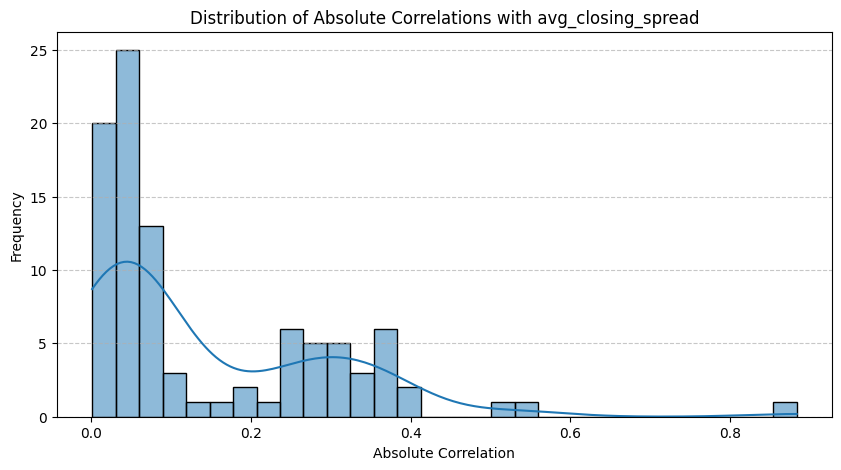

In [ ]:
# --- 2a: Feature-Target Correlation ---
print("\n--- Analysis: Feature-Target Correlation ---")
# Combine X_train and y_train temporarily for correlation calculation
train_corr_df = X_train_analysis[current_features].copy()
train_corr_df[target_variable] = y_train

# Calculate correlations with the target variable
correlations = train_corr_df.corr()[target_variable].drop(target_variable) # Drop self-correlation
correlations_abs = correlations.abs().sort_values(ascending=False)

print(f"Top 20 Features correlated with '{target_variable}' (Absolute Value):")
print(correlations_abs.head(20))
print(f"\nBottom 10 Features correlated with '{target_variable}' (Absolute Value):")
print(correlations_abs.tail(10))

# Plotting the distribution of absolute correlations
plt.figure(figsize=(10, 5))
sns.histplot(correlations_abs, bins=30, kde=True)
plt.title(f'Distribution of Absolute Correlations with {target_variable}')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# --- 2b: Feature-Feature Correlation ---
print("\n--- Analysis: Feature-Feature Correlation ---")
feature_corr_matrix = X_train_analysis.corr()

# Find highly correlated pairs
correlation_threshold = 0.9 # Identify pairs with correlation > this value
highly_correlated_pairs = []
cols = feature_corr_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)): # Iterate upper triangle
        corr_value = feature_corr_matrix.iloc[i, j]
        if abs(corr_value) > correlation_threshold:
            pair = (cols[i], cols[j], round(corr_value, 4))
            highly_correlated_pairs.append(pair)

print(f"Found {len(highly_correlated_pairs)} pairs with absolute correlation > {correlation_threshold}")

# Identify which feature in the pair to potentially drop (lower correlation with target)
features_to_consider_dropping_corr = set()
if highly_correlated_pairs:
    print("\nHighly Correlated Pairs (Feature1, Feature2, Correlation):")
    # Sort pairs for consistent display (optional)
    highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for pair in highly_correlated_pairs[:20]: # Show top 20 pairs
        f1, f2, corr_val = pair
        corr_f1_target = correlations_abs.get(f1, 0) # Get correlation with target
        corr_f2_target = correlations_abs.get(f2, 0)

        # Suggest dropping the one with lower absolute correlation to target
        drop_candidate = f1 if corr_f1_target < corr_f2_target else f2
        keep_candidate = f2 if drop_candidate == f1 else f1
        print(f"  - ('{f1}' [{corr_f1_target:.3f}], '{f2}' [{corr_f2_target:.3f}], {corr_val}) -> Suggest dropping: '{drop_candidate}'")
        features_to_consider_dropping_corr.add(drop_candidate) # Add suggestion to a set

    print(f"\nTotal features suggested for dropping due to high correlation: {len(features_to_consider_dropping_corr)}")
    # print("Candidates for dropping:", list(features_to_consider_dropping_corr)) # Uncomment to see full list


--- Analysis: Feature-Feature Correlation ---
Found 10 pairs with absolute correlation > 0.9

Highly Correlated Pairs (Feature1, Feature2, Correlation):
  - ('away_rp_percentPPA_Wk1_4' [0.079], 'away_rp_usage_Wk1_4' [0.081], 0.9796) -> Suggest dropping: 'away_rp_percentPPA_Wk1_4'
  - ('home_rp_percentPPA_Wk1_4' [0.102], 'home_rp_usage_Wk1_4' [0.107], 0.9783) -> Suggest dropping: 'home_rp_percentPPA_Wk1_4'
  - ('matchup_HO_v_AD_standardDowns_successRate' [0.034], 'matchup_HO_v_AD_successRate' [0.055], 0.9429) -> Suggest dropping: 'matchup_HO_v_AD_standardDowns_successRate'
  - ('away_defense_standardDowns_successRate_ewma_lag1' [0.000], 'away_defense_successRate_ewma_lag1' [0.000], 0.942) -> Suggest dropping: 'away_defense_successRate_ewma_lag1'
  - ('matchup_AO_v_HD_standardDowns_successRate' [0.022], 'matchup_AO_v_HD_successRate' [0.038], 0.942) -> Suggest dropping: 'matchup_AO_v_HD_standardDowns_successRate'
  - ('home_defense_standardDowns_successRate_ewma_lag1' [0.000], 'home_defe

In [ ]:
features_to_consider_dropping_corr

{'away_defense_successRate_ewma_lag1',
 'away_offense_successRate_ewma_lag1',
 'away_rp_percentPPA_Wk1_4',
 'home_defense_successRate_ewma_lag1',
 'home_offense_standardDowns_ppa_ewma_lag1',
 'home_offense_successRate_ewma_lag1',
 'home_rp_percentPPA_Wk1_4',
 'matchup_AO_v_HD_standardDowns_successRate',
 'matchup_HO_v_AD_standardDowns_ppa',
 'matchup_HO_v_AD_standardDowns_successRate'}

### Step 3: Model Based Feature Importance (Initial Run)


--- Analysis: Model-Based Feature Importance (GPU Accelerated XGBoost) ---
Training initial XGBoost model on GPU for feature importance...

Top 30 Features by XGBoost Importance (Gain):
                                             feature    importance
38                                     elo_diff_calc  18572.185547
71                             home_pregame_elo_calc   2200.688965
32                             away_pregame_elo_calc   1876.433228
24                        away_offense_ppa_ewma_lag1   1452.440186
68          home_offense_standardDowns_ppa_ewma_lag1   1241.113525
47                        home_defense_ppa_ewma_lag1   1105.712280
37                                   conference_game    864.756348
8                         away_defense_ppa_ewma_lag1    730.295532
111                                           season    695.336853
59   home_offense_passingDowns_successRate_ewma_lag1    571.092102
108                                     neutral_site    555.543396
63       

<ipython-input-54-16569ee76ce6>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')


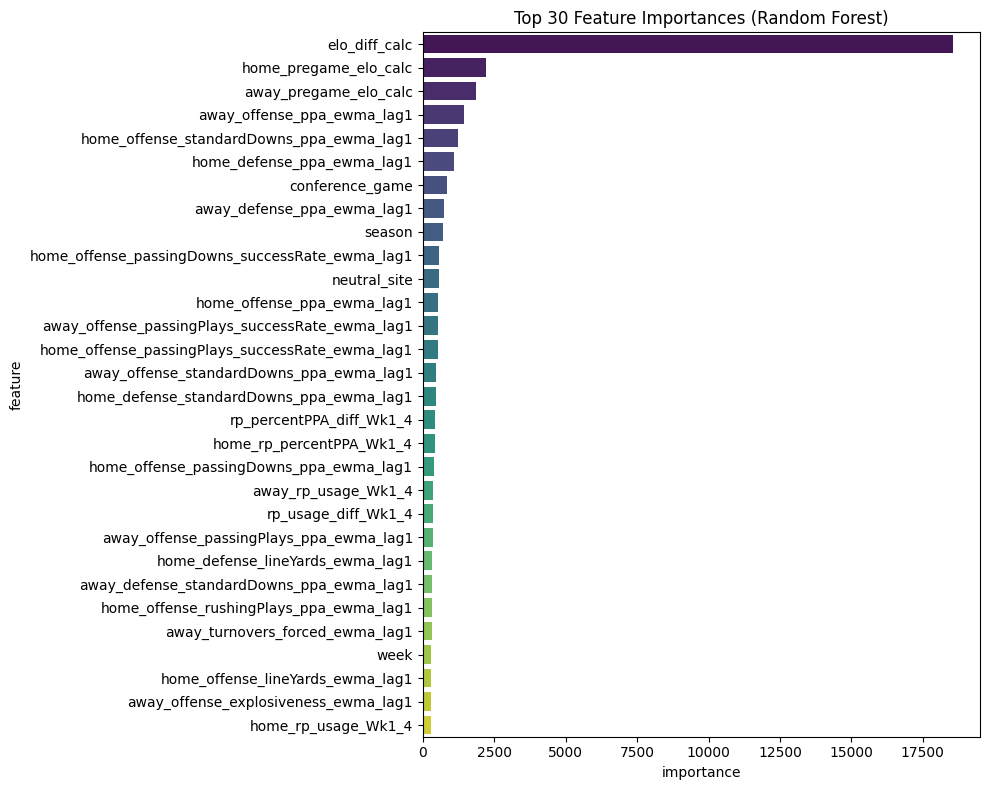


Features remaining after initial filtering & analysis: 96

--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---
Next Steps: Use validation set performance to iteratively select best feature subset based on these analyses.


In [ ]:
print("\n--- Analysis: Model-Based Feature Importance (GPU Accelerated XGBoost) ---")
import xgboost as xgb

# Use the imputed data (X_train, y_train)

# Define basic XGBoost parameters for importance calculation
xgb_importance_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'nthread': -1,
    # --- Enable GPU ---
    'device': 'cuda',
    # ------------------
    # Use relatively simple settings for speed
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}
num_round_importance = 100 # Fewer rounds might suffice for ranking

print(f"Training initial XGBoost model on GPU for feature importance...")
dtrain_importance = xgb.DMatrix(X_train_analysis[current_features], label=y_train)
model_importance = xgb.train(
    xgb_importance_params,
    dtrain_importance,
    num_boost_round=num_round_importance,
    verbose_eval=False
)

# Get feature importances (using 'gain' is often good)
importance_dict = model_importance.get_score(importance_type='gain')
if not importance_dict:
    importance_dict = model_importance.get_score(importance_type='weight') # Fallback

# Create DataFrame - Need to handle features potentially not used
all_features = X_train.columns.tolist()
importance_values = [importance_dict.get(f, 0) for f in all_features] # Assign 0 if feature not used

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importance_values
}).sort_values('importance', ascending=False)


print("\nTop 30 Features by XGBoost Importance (Gain):")
print(feature_importance_df.head(30))
print("\nBottom 10 Features by XGBoost Importance (Gain):")
print(feature_importance_df.tail(10))

# Optional: Plot top N feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')
plt.title('Top 30 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Store the current list of features after initial filtering
features_after_initial_analysis = current_features
print(f"\nFeatures remaining after initial filtering & analysis: {len(features_after_initial_analysis)}")

print("\n--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---")
print("Next Steps: Use validation set performance to iteratively select best feature subset based on these analyses.")
del X_train_analysis, X_val_analysis, train_corr_df # Cleanup

## Steps 4,5: Regularization and Iteration

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

### Define Candidate Feature Sets

In [ ]:
candidate_feature_sets = {}

# Set A: Basic Features Only (Baseline)
candidate_feature_sets['A_Basic'] = [f for f in basic_features if f in features_after_initial_analysis]

# Set B: Top N by Absolute Correlation with Target
N_corr = 50 # Example: Top 100
top_corr_features = correlations_abs.head(N_corr).index.tolist()
candidate_feature_sets[f'B_Top{N_corr}_Corr'] = [f for f in top_corr_features if f in features_after_initial_analysis]

# Set C: Top N by Random Forest Importance
N_rf = 50 # Example: Top 100
top_rf_features = feature_importance_df['feature'].head(N_rf).tolist()
candidate_feature_sets[f'C_Top{N_rf}_RF_Importance'] = [f for f in top_rf_features if f in features_after_initial_analysis]

# Set D: Features after removing high inter-feature correlation candidates
# Start with all features after initial filtering
features_after_corr_drop = [f for f in features_after_initial_analysis if f not in features_to_consider_dropping_corr]
candidate_feature_sets['D_Reduced_Correlation'] = features_after_corr_drop

# Set E: All features remaining after initial filtering (Variance/Missing)
candidate_feature_sets['E_All_Initial_Filtered'] = features_after_initial_analysis

# Optional: Combine Top RF + Basic Features
combined_rf_basic = list(set(top_rf_features + candidate_feature_sets['A_Basic']))
candidate_feature_sets[f'F_Top{N_rf}_RF_plus_Basic'] = [f for f in combined_rf_basic if f in features_after_initial_analysis]


print(f"\nDefined {len(candidate_feature_sets)} candidate feature sets:")
for name, features in candidate_feature_sets.items():
    print(f"  - {name}: {len(features)} features")


Defined 6 candidate feature sets:
  - A_Basic: 7 features
  - B_Top50_Corr: 50 features
  - C_Top50_RF_Importance: 50 features
  - D_Reduced_Correlation: 90 features
  - E_All_Initial_Filtered: 96 features
  - F_Top50_RF_plus_Basic: 50 features


### Choose Model for Evaluation: XGBoost

In [ ]:
# Define XGBoost parameters (use reasonable defaults or slightly tuned values)
# We are NOT tuning hyperparameters here, just evaluating feature sets
xgb_params = {
    'objective': 'reg:squarederror', # Regression task
    'eval_metric': 'rmse',           # Evaluation metric for XGBoost internal use
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Max tree depth (control complexity)
    'subsample': 0.8,                # Fraction of samples used per tree
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,
    'nthread': -1, # Use all available CPU threads
    'device': 'cuda'
    # Enable internal NaN handling if using non-imputed data:
    # 'missing': np.nan # Tells XGBoost to handle NaNs
}
num_boost_round = 100 # Number of boosting rounds (trees)

### Create Betting Model

In [ ]:
import math
from tqdm import tqdm

def simulate_betting(simulation_input_df):
    """
    Simulates the betting strategy on provided data with predictions.
    Expects 'predicted_spread_market', 'avg_opening_spread', 'home_points',
    'away_points', and other game identifiers.
    Returns a DataFrame with results for each potential bet.
    """
    results = []

    # Ensure necessary columns exist and drop rows with missing critical data for simulation
    required_cols = ['id', 'season', 'week', 'home_team', 'away_team', 'home_points', 'away_points',
                     'avg_opening_spread', 'neutral_site', # neutral_site might not be needed if HFA baked into prediction
                     'predicted_spread_market'] # This comes from the model now
    sim_df = simulation_input_df[required_cols].copy()
    sim_df.dropna(subset=['avg_opening_spread', 'home_points', 'away_points',
                           'predicted_spread_market'], inplace=True) # Crucial dropna

    if sim_df.empty:
        print("Warning: No games available for betting simulation after dropping NaNs.")
        return pd.DataFrame() # Return empty DataFrame

    # print(f"Simulating bets for {len(sim_df)} games...") # Optional debug

    for index, game in sim_df.iterrows():
        predicted_spread = game['predicted_spread_market']
        opening_spread = game['avg_opening_spread']

        bet_on = None
        profit_loss = 0.0
        result = 'no_bet' # Default if threshold not met
        difference = predicted_spread - opening_spread

        # REVISED Trigger Logic
        if abs(difference) > BET_THRESHOLD:
            if predicted_spread > opening_spread:
                bet_on = 'away'
            elif predicted_spread < opening_spread:
                bet_on = 'home'
            # else: difference == 0, no bet

        # Grade the bet if one was placed
        if bet_on:
            # REVISED: Actual margin from AWAY team perspective
            actual_margin = game['away_points'] - game['home_points']

            if bet_on == 'away':
                if actual_margin > opening_spread: result, profit_loss = 'win', WIN_PAYOUT
                elif actual_margin < opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
                else: result, profit_loss = 'push', 0
            elif bet_on == 'home':
                if actual_margin < opening_spread: result, profit_loss = 'win', WIN_PAYOUT
                elif actual_margin > opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
                else: result, profit_loss = 'push', 0

        results.append({
            'game_id': game['id'],
            'season': game['season'],
            'predicted_spread_market': predicted_spread,
            'opening_spread': opening_spread,
            'bet_on': bet_on,
            'result': result,
            'profit_loss': profit_loss
        })

    return pd.DataFrame(results)

### Create Evaluation Function

In [ ]:
print([f for f in val_df.columns if 'elo' in f])

['home_pregame_elo', 'home_postgame_elo', 'away_pregame_elo', 'away_postgame_elo', 'home_pregame_elo_calc', 'away_pregame_elo_calc', 'elo_diff_calc']


In [ ]:
!pip install optuna
# Optional: Integrate betting simulation (requires val_df to have opening spreads & scores)
# Ensure val_df has needed columns if simulating bets:
val_required_cols = ['avg_opening_spread', 'home_points', 'away_points', 'neutral_site', 'id', 'season', 'week', 'home_team', 'away_team', 'home_pregame_elo_calc', 'away_pregame_elo_calc']


def evaluate_feature_set_with_bets_nan(feature_set_name, features, xgb_params, num_round, X_train_fs_nan, y_train_fs, X_val_fs_nan, y_val_fs, val_df):
    """Trains XGBoost and evaluates on the validation set."""
    print(f"\n--- Evaluating Feature Set: {feature_set_name} ({len(features)} features) ---")
    start_time = time.time()

    # Select features - using the PRE-IMPUTED data for this loop
    X_train_subset = X_train_fs_nan[features]
    X_val_subset = X_val_fs_nan[features]

    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train_subset, label=y_train, enable_categorical=False)
    dval = xgb.DMatrix(X_val_subset, label=y_val, enable_categorical=False)

    # Train the model
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_round,
        evals=watchlist,
        verbose_eval=False, # Suppress verbose output during training
        # early_stopping_rounds=10 # Optional: Stop early if validation RMSE doesn't improve
    )

    # Predict on validation set
    y_pred_val = model.predict(dval)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_val_fs, y_pred_val))
    mae = mean_absolute_error(y_val_fs, y_pred_val)
    # Calculate correlation using pandas Series for correct handling
    predictions_series = pd.Series(y_pred_val, index=y_val_fs.index)
    correlation = y_val_fs.corr(predictions_series)
    bias = np.mean(y_pred_val - y_val_fs)

    # --- Optional: Betting Simulation ---
    betting_units = np.nan # Placeholder
    betting_roi = np.nan
    betting_win_rate = np.nan
    # Uncomment and adapt if you have the simulator and necessary columns in val_df
    try:
      # Create a temporary df with predictions and necessary info for sim
      sim_input_df = val_df[val_required_cols].copy()
      sim_input_df['predicted_spread_market'] = y_pred_val
      #Note: The simulator needs the ELO_SPREAD_DIVISOR and HFA from Elo tuning
      #Pass them appropriately if needed by the simulator function
      betting_results = simulate_betting(sim_input_df) # Need elo params
      betting_units = betting_results['profit_loss'].sum()
      total_bets = len(betting_results[betting_results['bet_on'].notna()])
      total_wins = len(betting_results[betting_results['result'] == 'win'])
      total_losses = len(betting_results[betting_results['result'] == 'loss'])
      if (total_wins + total_losses) > 0:
          betting_win_rate = total_wins / (total_wins + total_losses)
      total_risked = (total_wins + total_losses)  # LOSS_AMOUNT=1
      if total_risked > 0:
          betting_roi = (betting_units / total_risked) * 100
    except Exception as e:
      print(f"Betting simulation failed for {feature_set_name}: {e}")
    # ------------------------------------

    end_time = time.time()
    duration = end_time - start_time

    results = {
        'Set Name': feature_set_name,
        'Num Features': len(features),
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation,
        'Bias': bias,
        'Betting Units': betting_units, # Will be NaN if simulation skipped
        'Betting Win Rate': betting_win_rate, # Will be NaN if simulation skipped
        'Betting ROI': betting_roi, # Will be NaN if simulation skipped
        'Eval Time (s)': duration
    }

    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Correlation: {correlation:.4f}, Bias: {bias:.4f}, Time: {duration:.1f}s")
    # print(f"  Betting: Units={betting_units:.2f}, Win Rate={betting_win_rate:.2%}, ROI={betting_roi:.2f}%") # Uncomment if sim runs

    return results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.8 MB/s eta 0:00:00


### Run the Loop

In [ ]:
all_results = []
for name, feature_list in candidate_feature_sets.items():
    # Ensure feature list is not empty and features exist in X_train
    valid_features = [f for f in feature_list if f in X_train.columns]
    if not valid_features:
        print(f"\n--- Skipping Feature Set: {name} (No valid features found) ---")
        continue
    if len(valid_features) < len(feature_list):
         print(f"\nWarning: Some features for set '{name}' were not found in X_train after filtering.")

    result = evaluate_feature_set_with_bets_nan(name, valid_features, xgb_params, num_boost_round, X_train, y_train, X_val, y_val, val_df)
    all_results.append(result)


--- Evaluating Feature Set: A_Basic (7 features) ---
  RMSE: 5.9103, MAE: 4.5935, Correlation: 0.9072, Bias: 0.3813, Time: 1.4s

--- Evaluating Feature Set: B_Top50_Corr (50 features) ---
  RMSE: 5.1701, MAE: 4.0328, Correlation: 0.9303, Bias: -0.2749, Time: 3.2s

--- Evaluating Feature Set: C_Top50_RF_Importance (50 features) ---
  RMSE: 5.2185, MAE: 4.0944, Correlation: 0.9285, Bias: 0.3640, Time: 1.8s

--- Evaluating Feature Set: D_Reduced_Correlation (90 features) ---
  RMSE: 5.2396, MAE: 4.0747, Correlation: 0.9276, Bias: 0.2030, Time: 2.0s

--- Evaluating Feature Set: E_All_Initial_Filtered (96 features) ---
  RMSE: 5.2279, MAE: 4.0664, Correlation: 0.9280, Bias: 0.2765, Time: 1.9s

--- Evaluating Feature Set: F_Top50_RF_plus_Basic (50 features) ---
  RMSE: 5.2280, MAE: 4.0958, Correlation: 0.9282, Bias: 0.3421, Time: 1.9s


### Present Results

In [ ]:
print("\n--- Feature Set Evaluation Summary ---")
results_df = pd.DataFrame(all_results)
results_df.sort_values(by='RMSE', ascending=True, inplace=True) # Sort by primary metric (RMSE)

# Format columns for display
results_df['RMSE'] = results_df['RMSE'].map('{:.4f}'.format)
results_df['MAE'] = results_df['MAE'].map('{:.4f}'.format)
results_df['Correlation'] = results_df['Correlation'].map('{:.4f}'.format)
results_df['Bias'] = results_df['Bias'].map('{:.4f}'.format)
results_df['Betting Units'] = results_df['Betting Units'].map('{:.2f}'.format)
results_df['Betting Win Rate'] = results_df['Betting Win Rate'].map('{:.2%}'.format)
results_df['Betting ROI'] = results_df['Betting ROI'].map('{:.2f}%'.format)
results_df['Eval Time (s)'] = results_df['Eval Time (s)'].map('{:.1f}'.format)


print(results_df.to_string(index=False))

print("\n--- Phase 2, Steps 4 & 5 Complete ---")
print("Evaluated candidate feature sets on the validation data.")
print("Next Steps: Analyze results, potentially refine feature sets and iterate, then proceed to hyperparameter tuning (Phase 3) on the chosen set(s).")


--- Feature Set Evaluation Summary ---
              Set Name  Num Features   RMSE    MAE Correlation    Bias Betting Units Betting Win Rate Betting ROI Eval Time (s)
          B_Top50_Corr            50 5.1701 4.0328      0.9303 -0.2749        -40.24           50.77%      -3.09%           3.2
 C_Top50_RF_Importance            50 5.2185 4.0944      0.9285  0.3640        -32.88           51.07%      -2.51%           1.8
E_All_Initial_Filtered            96 5.2279 4.0664      0.9280  0.2765        -42.97           50.65%      -3.30%           1.9
 F_Top50_RF_plus_Basic            50 5.2280 4.0958      0.9282  0.3421        -35.15           50.99%      -2.67%           1.9
 D_Reduced_Correlation            90 5.2396 4.0747      0.9276  0.2030        -33.52           51.04%      -2.57%           2.0
               A_Basic             7 5.9103 4.5935      0.9072  0.3813        -69.51           49.62%      -5.27%           1.4

--- Phase 2, Steps 4 & 5 Complete ---
Evaluated candidate featu

# Phase 3: Model Selection and Training

### Select Best Feature Set

In [ ]:
# Choose the set name that performed best in the previous step's results_df
# Example: Assuming 'D_Reduced_Correlation' was best
# best_feature_set_name = 'D_Reduced_Correlation'
# If you manually created the list previously:
# best_features = features_after_corr_drop # Or whichever list corresponds to the best set
# Or retrieve from the candidate dictionary:
best_feature_set_name = results_df.iloc[0]['Set Name'] # Assumes results_df sorted by best metric
best_features = candidate_feature_sets[best_feature_set_name]

print(f"Selected best feature set for tuning: '{best_feature_set_name}' ({len(best_features)} features)")

# Prepare final training and validation data with ONLY the selected features
# Using the temporarily imputed data from the previous step for consistency during tuning
X_train_best = X_train[best_features].copy()
X_val_best = X_val[best_features].copy()

print(f"Using feature shapes: X_train_best={X_train_best.shape}, X_val_best={X_val_best.shape}")

Selected best feature set for tuning: 'B_Top50_Corr' (50 features)
Using feature shapes: X_train_best=(5583, 50), X_val_best=(1467, 50)


### Define Objective Function for Optuna

In [ ]:
import optuna

def objective_xgb_nan(trial, X_train_hp_nan, y_train_hp, X_val_hp_nan, y_val_hp, validation_df_hp):
    """Objective function for Optuna XGBoost hyperparameter tuning."""

    # --- 3. Define Search Space ---
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'nthread': -1, # Use all cores
        'device': 'cuda', # Enable GPU Acceleration
        # Parameters to tune:
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),             # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 9),                  # Max tree depth
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),            # Row subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Feature subsampling
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),   # Min samples in leaf node
        'gamma': trial.suggest_float('gamma', 0, 0.5),                      # Min loss reduction for split
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),       # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),         # L1 regularization
        # 'missing': np.nan # Enable if using non-imputed data
    }

    # Fixed number of boosting rounds for tuning (can be tuned itself later)
    # Or use early stopping within the training call
    num_boost_round_hp = 200 # Increase rounds for tuning?

    # Prepare data
    dtrain = xgb.DMatrix(X_train_hp_nan, label=y_train_hp)
    dval = xgb.DMatrix(X_val_hp_nan, label=y_val_hp)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    # Train model with suggested parameters
    # Using early stopping is highly recommended during tuning
    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round_hp,
        evals=watchlist,
        early_stopping_rounds=25, # Stop if validation RMSE doesn't improve for 25 rounds
        verbose_eval=False # Keep quiet during Optuna trials
    )

    # Evaluate on validation set
    y_pred_val_hp = bst.predict(dval, iteration_range=(0, bst.best_iteration)) # Use best iteration
    rmse_val = np.sqrt(mean_squared_error(y_val_hp, y_pred_val_hp))

    # --- Optional: Calculate betting simulation for this trial ---
    # This adds significant time to each trial but directly optimizes for bets

    run_betting_sim_in_tuning = False # Set to False to speed up tuning based only on RMSE

    if run_betting_sim_in_tuning:
        try:
            sim_input_df_hp = validation_df_hp[val_required_cols].copy()
            sim_input_df_hp['predicted_spread_market'] = pd.Series(y_pred_val_hp, index=validation_df_hp.index) # Align index
            betting_results_hp = simulate_betting(sim_input_df_hp)

            if not betting_results_hp.empty:
                betting_units_hp = betting_results_hp['profit_loss'].sum()
                bets_placed_df_hp = betting_results_hp[betting_results_hp['bet_on'].notna()]
                wins_hp = len(bets_placed_df_hp[bets_placed_df_hp['result'] == 'win'])
                losses_hp = len(bets_placed_df_hp[bets_placed_df_hp['result'] == 'loss'])
                if (wins_hp + losses_hp) > 0:
                    total_risked_hp = (wins_hp + losses_hp) * LOSS_AMOUNT
                    roi_hp = (betting_units_hp / total_risked_hp) * 100 if total_risked_hp > 0 else 0.0
                else:
                     roi_hp = 0.0 # Or NaN
                 # Store ROI as user attribute to see it, but still optimize RMSE
                trial.set_user_attr("val_roi", roi_hp)
                trial.set_user_attr("val_units", betting_units_hp)
            else:
                 trial.set_user_attr("val_roi", np.nan)
                 trial.set_user_attr("val_units", 0.0)

        except Exception as e:
             print(f"Warning: Betting sim failed in trial {trial.number}: {e}")
             trial.set_user_attr("val_roi", np.nan)
             trial.set_user_attr("val_units", np.nan)

    # Return the metric to minimize (Validation RMSE)
    return rmse_val

### Run Optuna Study

In [ ]:
N_TRIALS_HP = 100 # Number of hyperparameter combinations to test (adjust as needed)

print(f"\nStarting Optuna hyperparameter search ({N_TRIALS_HP} trials)...")
study_hp = optuna.create_study(direction='minimize', study_name='XGBoost Spread Prediction NaN') # Minimize RMSE

X_train_best_nan = X_train[best_features].copy()
X_val_best_nan = X_val[best_features].copy()

# Pass necessary dataframes via lambda function
study_hp.optimize(
    lambda trial: objective_xgb_nan(trial, X_train_best_nan, y_train, X_val_best_nan, y_val, val_df),
    n_trials=N_TRIALS_HP,
    show_progress_bar=True
)

[I 2025-04-14 22:12:19,847] A new study created in memory with name: XGBoost Spread Prediction NaN



Starting Optuna hyperparameter search (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-14 22:12:20,678] Trial 0 finished with value: 5.953520799957329 and parameters: {'eta': 0.010247340537583395, 'max_depth': 3, 'subsample': 0.7999454226120658, 'colsample_bytree': 0.9361198128450234, 'min_child_weight': 10, 'gamma': 0.12783098881066146, 'lambda': 0.02911278542529156, 'alpha': 0.00017289605553052207}. Best is trial 0 with value: 5.953520799957329.
[I 2025-04-14 22:12:21,595] Trial 1 finished with value: 5.221375026536477 and parameters: {'eta': 0.02753580987687694, 'max_depth': 4, 'subsample': 0.9538494346119346, 'colsample_bytree': 0.6011600504418662, 'min_child_weight': 4, 'gamma': 0.2680637722027703, 'lambda': 0.0003422950999773474, 'alpha': 0.002048045032954678}. Best is trial 1 with value: 5.221375026536477.
[I 2025-04-14 22:12:22,248] Trial 2 finished with value: 5.235919588855152 and parameters: {'eta': 0.17091787917679493, 'max_depth': 3, 'subsample': 0.8309271141581729, 'colsample_bytree': 0.9289620351432988, 'min_child_weight': 9, 'gamma': 0.44246392

### Identify Best Hyperparameters

In [ ]:
print("\nOptimization Finished.")
print(f"Number of finished trials: {len(study_hp.trials)}")
print(f"Best trial (Validation RMSE): {study_hp.best_value:.4f}")

print("Best hyperparameters:")
best_xgb_params = study_hp.best_params
for key, value in best_xgb_params.items():
    print(f"  {key}: {value}")

# --- Optional: Show best trial's betting performance ---
best_trial_info = study_hp.best_trial
if 'val_roi' in best_trial_info.user_attrs:
    print(f"\nBest Trial's Validation Betting Performance:")
    print(f"  Units: {best_trial_info.user_attrs.get('val_units', 'N/A'):.2f}")
    print(f"  ROI:   {best_trial_info.user_attrs.get('val_roi', 'N/A'):.2f}%")


# --- Retrain Final Model with Best Parameters (Optional here, usually done before Test Set) ---
# You would typically save these `best_xgb_params` and use them to train a final model
# on the *combined* training + validation data before predicting on the test set.
# For now, we have identified the best settings based on validation performance.

print("\n--- Phase 3 (Hyperparameter Tuning) Complete ---")
print("Identified best XGBoost hyperparameters based on validation set performance.")
print("Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.")


Optimization Finished.
Number of finished trials: 100
Best trial (Validation RMSE): 5.1099
Best hyperparameters:
  eta: 0.02649841216197582
  max_depth: 6
  subsample: 0.6287563222299242
  colsample_bytree: 0.5418424547712584
  min_child_weight: 1
  gamma: 0.3003764967986076
  lambda: 0.01005317351468817
  alpha: 1.775157519897494e-05

--- Phase 3 (Hyperparameter Tuning) Complete ---
Identified best XGBoost hyperparameters based on validation set performance.
Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.


# Phase 4 Final Evaluation

### Define Train+Validation and Test Sets

In [ ]:
TEST_START_SEASON = VALIDATION_END_SEASON + 1

print(f"Using final split points:")
print(f"  Train+Validation: Seasons <= {VALIDATION_END_SEASON}")
print(f"  Test:             Seasons >= {TEST_START_SEASON}")

train_val_df = master_df[master_df['season'] <= VALIDATION_END_SEASON].copy()
test_df = master_df[master_df['season'] >= TEST_START_SEASON].copy()

print(f"\nData Shapes:")
print(f"  Train+Validation Set: {train_val_df.shape}")
print(f"  Test Set:             {test_df.shape}")

if test_df.empty:
    print("\nERROR: Test set is empty. Cannot perform final evaluation.")
    # Exit or handle appropriately
    exit()


Using final split points:
  Train+Validation: Seasons <= 2022
  Test:             Seasons >= 2023

Data Shapes:
  Train+Validation Set: (7050, 257)
  Test Set:             (1502, 257)


### Prepare Data for Final Model

In [ ]:
# Select the best features identified earlier
X_train_val_nan = train_val_df[best_features].copy()
y_train_val = train_val_df[target_variable]

X_test_nan = test_df[best_features].copy()
y_test = test_df[target_variable]

print(f"\nFeature matrix shapes for final model:")
print(f"  X_train_val: {X_train_val_nan.shape}")
print(f"  X_test:      {X_test_nan.shape}")

# --- Handle Missing Values (Strategy Decision) ---
# IMPORTANT: Use the SAME strategy as during hyperparameter tuning.
# If XGBoost's internal NaN handling was used (recommended), do nothing here.
# If imputation was done (e.g., median), apply it here using values
# calculated ONLY from the original *training* set (train_df).

# Assuming XGBoost internal NaN handling (if tree_method='gpu_hist' was used):
print("\nAssuming XGBoost will handle NaNs internally (no imputation applied).")
# If you need to impute (e.g., using training median):
# features_with_nan_final = X_train_val.columns[X_train_val.isnull().any()].tolist()
# # Calculate median ONLY from original training data (train_df must exist)
# imputation_values_final = train_df[features_with_nan_final].median()
# print(f"Applying median imputation based on original training data to {len(features_with_nan_final)} columns...")
# X_train_val.fillna(imputation_values_final, inplace=True)
# X_test.fillna(imputation_values_final, inplace=True)
# print(f"NaN check after imputation (X_train_val): {X_train_val.isnull().sum().sum()}")
# print(f"NaN check after imputation (X_test):      {X_test.isnull().sum().sum()}")

# Prepare data for XGBoost
print("Preparing DMatrix for XGBoost...")
dtrain_val = xgb.DMatrix(X_train_val_nan, label=y_train_val)
dtest = xgb.DMatrix(X_test_nan, label=y_test)



Feature matrix shapes for final model:
  X_train_val: (7050, 50)
  X_test:      (1502, 50)

Assuming XGBoost will handle NaNs internally (no imputation applied).
Preparing DMatrix for XGBoost...


### Train Final XGBoost Model

In [ ]:
# Combine base parameters with the best ones found by Optuna
final_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'nthread': -1,
    # Add 'tree_method': 'gpu_hist' IF you are using a GPU runtime for this final training
    'device': 'cuda'
}
final_xgb_params.update(best_xgb_params) # Add tuned parameters

# Determine the number of boosting rounds
# Option 1: Use a fixed number (e.g., the one used in tuning or slightly more)
# num_boost_round_final = 200 # Example
# Option 2: If you logged bst.best_iteration from the best Optuna trial, use that.
# best_iteration = ??? # Need to retrieve this value from tuning results if possible
# Option 3: Train with early stopping against a small validation split *of the train_val_df*
# This is safer but adds complexity. Let's use a fixed number for now.
num_boost_round_final = 200 # Use the value determined during tuning or a reasonable default
print(f"Training final XGBoost model with {len(best_features)} features for {num_boost_round_final} rounds...")
print("Using hyperparameters:", final_xgb_params)

start_train_time = time.time()
final_model = xgb.train(
    final_xgb_params,
    dtrain_val,
    num_boost_round=num_boost_round_final,
    evals=[(dtrain_val, 'train'), (dtest, 'test')], # Monitor performance on test set during training
    verbose_eval=50 # Print progress every 50 rounds
)
end_train_time = time.time()
print(f"Final model training finished in {end_train_time - start_train_time:.2f} seconds.")

Training final XGBoost model with 50 features for 200 rounds...
Using hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': -1, 'device': 'cuda', 'eta': 0.02649841216197582, 'max_depth': 6, 'subsample': 0.6287563222299242, 'colsample_bytree': 0.5418424547712584, 'min_child_weight': 1, 'gamma': 0.3003764967986076, 'lambda': 0.01005317351468817, 'alpha': 1.775157519897494e-05}
[0]	train-rmse:13.89848	test-rmse:12.90511
[50]	train-rmse:6.81260	test-rmse:6.32637
[100]	train-rmse:5.08598	test-rmse:5.26365
[150]	train-rmse:4.55543	test-rmse:5.17601
[199]	train-rmse:4.25665	test-rmse:5.16512
Final model training finished in 0.93 seconds.


### Predict on Test Set

In [ ]:
print("\nPredicting on Test Set...")
y_pred_test = final_model.predict(dtest)
predictions_test_series = pd.Series(y_pred_test, index=y_test.index)


Predicting on Test Set...


### Evaluate Statistical Metrics on Test Set

In [ ]:
print("\n--- Test Set Statistical Performance ---")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
correlation_test = y_test.corr(predictions_test_series)
bias_test = np.mean(y_pred_test - y_test)
r2_test = r2_score(y_test, y_pred_test) # R-squared

print(f"  RMSE:        {rmse_test:.4f}")
print(f"  MAE:         {mae_test:.4f}")
print(f"  Correlation: {correlation_test:.4f}")
print(f"  Bias:        {bias_test:.4f}")
print(f"  R-squared:   {r2_test:.4f}")


--- Test Set Statistical Performance ---
  RMSE:        5.1651
  MAE:         3.9951
  Correlation: 0.9210
  Bias:        -0.2921
  R-squared:   0.8470


### Plot Predictions vs. Actuals for Test Set

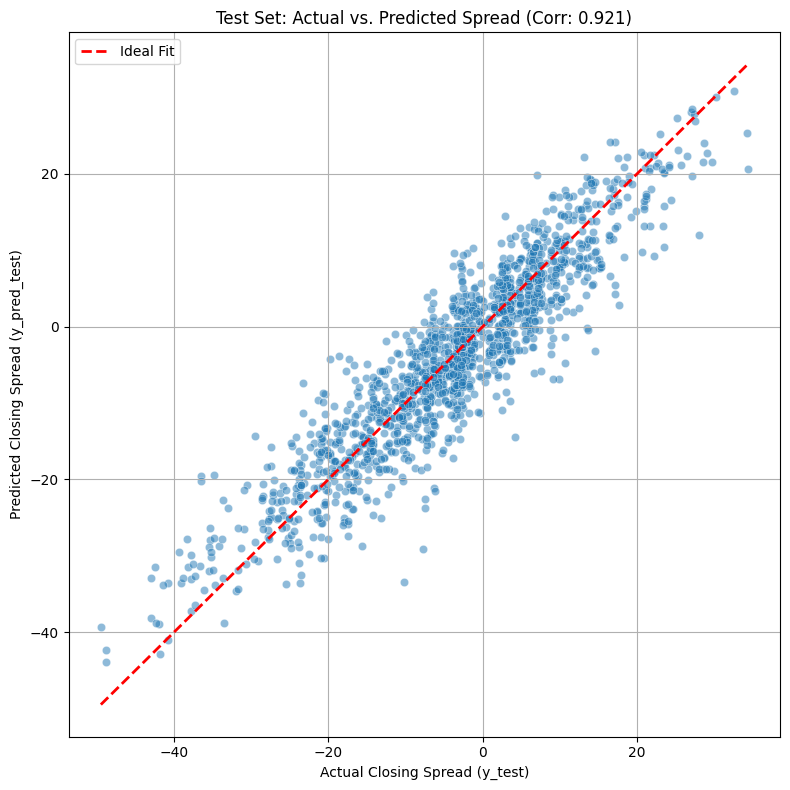

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal Fit')
plt.xlabel("Actual Closing Spread (y_test)")
plt.ylabel("Predicted Closing Spread (y_pred_test)")
plt.title(f"Test Set: Actual vs. Predicted Spread (Corr: {correlation_test:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate Betting Performance on Test Set

In [ ]:
print("\n--- Test Set Betting Performance ---")

# Prepare input for the simulator
# Select necessary columns from the original test_df
sim_input_test_df = test_df[val_required_cols].copy()
# Add the predictions, ensuring index alignment
sim_input_test_df['predicted_spread_market'] = predictions_test_series

# Run the simulation
test_betting_results = simulate_betting(sim_input_test_df)

if test_betting_results.empty:
    print("No bets were placed on the test set according to the strategy.")
else:
    # Aggregate results
    test_total_units = test_betting_results['profit_loss'].sum()
    test_bets_placed_df = test_betting_results[test_betting_results['bet_on'].notna()]
    test_total_bets = len(test_bets_placed_df)
    test_wins = len(test_bets_placed_df[test_bets_placed_df['result'] == 'win'])
    test_losses = len(test_bets_placed_df[test_bets_placed_df['result'] == 'loss'])
    test_pushes = len(test_bets_placed_df[test_bets_placed_df['result'] == 'push'])

    test_win_rate = test_wins / (test_wins + test_losses) if (test_wins + test_losses) > 0 else np.nan
    test_total_risked = (test_wins + test_losses) * LOSS_AMOUNT
    test_roi = (test_total_units / test_total_risked) * 100 if test_total_risked > 0 else 0.0

    print(f"  Total Bets:   {test_total_bets}")
    print(f"  Wins:         {test_wins}")
    print(f"  Losses:       {test_losses}")
    print(f"  Pushes:       {test_pushes}")
    print(f"  Win Rate:     {test_win_rate:.2%}")
    print(f"  Total Units:  {test_total_units:+.2f}")
    print(f"  ROI:          {test_roi:.2f}%")


--- Test Set Betting Performance ---
  Total Bets:   1376
  Wins:         697
  Losses:       672
  Pushes:       7
  Win Rate:     50.91%
  Total Units:  -38.43
  ROI:          -2.81%


### Plot Cumulative Units over Time

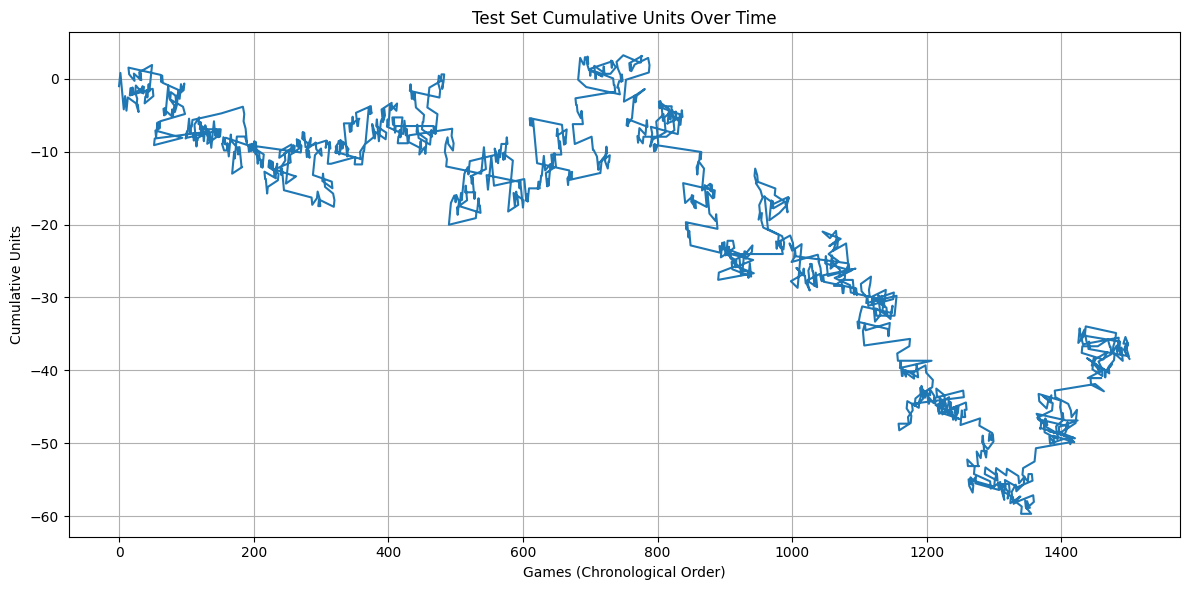

In [ ]:
# Optional: Plot cumulative units over time for the test set
test_betting_results = pd.merge(test_betting_results[['game_id', 'profit_loss']],
                                test_df[['id', 'season', 'week']],
                                left_on='game_id', right_on='id')
test_betting_results['game_date_order'] = test_betting_results['season'] * 100 + test_betting_results['week']
test_betting_results.sort_values('game_date_order', inplace=True)
test_betting_results['cumulative_units'] = test_betting_results['profit_loss'].cumsum()

plt.figure(figsize=(12, 6))
test_betting_results['cumulative_units'].plot()
plt.title('Test Set Cumulative Units Over Time')
plt.xlabel('Games (Chronological Order)')
plt.ylabel('Cumulative Units')
plt.grid(True)
plt.tight_layout()
plt.show()